In [1]:
import torch
import matplotlib.pyplot as plt
import scipy.io as scio
import numpy as np
import physo
from physo.learn import monitoring
from physo.task  import benchmark

# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

# Seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  32
Recommended config {'parallel_mode': False, 'n_cpus': 32}
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo f

c:\users\dell\physo\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
c:\users\dell\physo\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
# Load origin dataset and generate clean data
train_data = scio.loadmat('../data/Diffusion_flow.mat')
rho = train_data['rho']
rho_y = train_data['rho_y']
rho_yy = train_data['rho_yy']
rho_3y = train_data['rho_3y']
X_array = np.stack((rho_y, rho_yy, rho_3y), axis=0)

# ------ Constants ------
D = torch.tensor(np.array(1.399e-5)).to(DEVICE)
miu = torch.tensor(np.array(2.079e-5)).to(DEVICE)

# Lambda = torch.tensor(np.array(6.2497e-08)).to(DEVICE)
# tau = torch.tensor(np.array(1.644e-10)).to(DEVICE)

# pi = torch.tensor(np.array(torch.pi)).to(DEVICE)

Y = rho_yy * (1.399e-5)  # Target variable is the rho_t.

X_array = X_array.reshape((X_array.shape[0],X_array.shape[1]))
Y = Y.reshape((Y.shape[0],))

X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(Y).to(DEVICE)

If using fully clean data

$Y = D * rho_{yy}$

$D = \frac{3\pi}{16}\cdot\frac{\lambda^2}{\tau}$

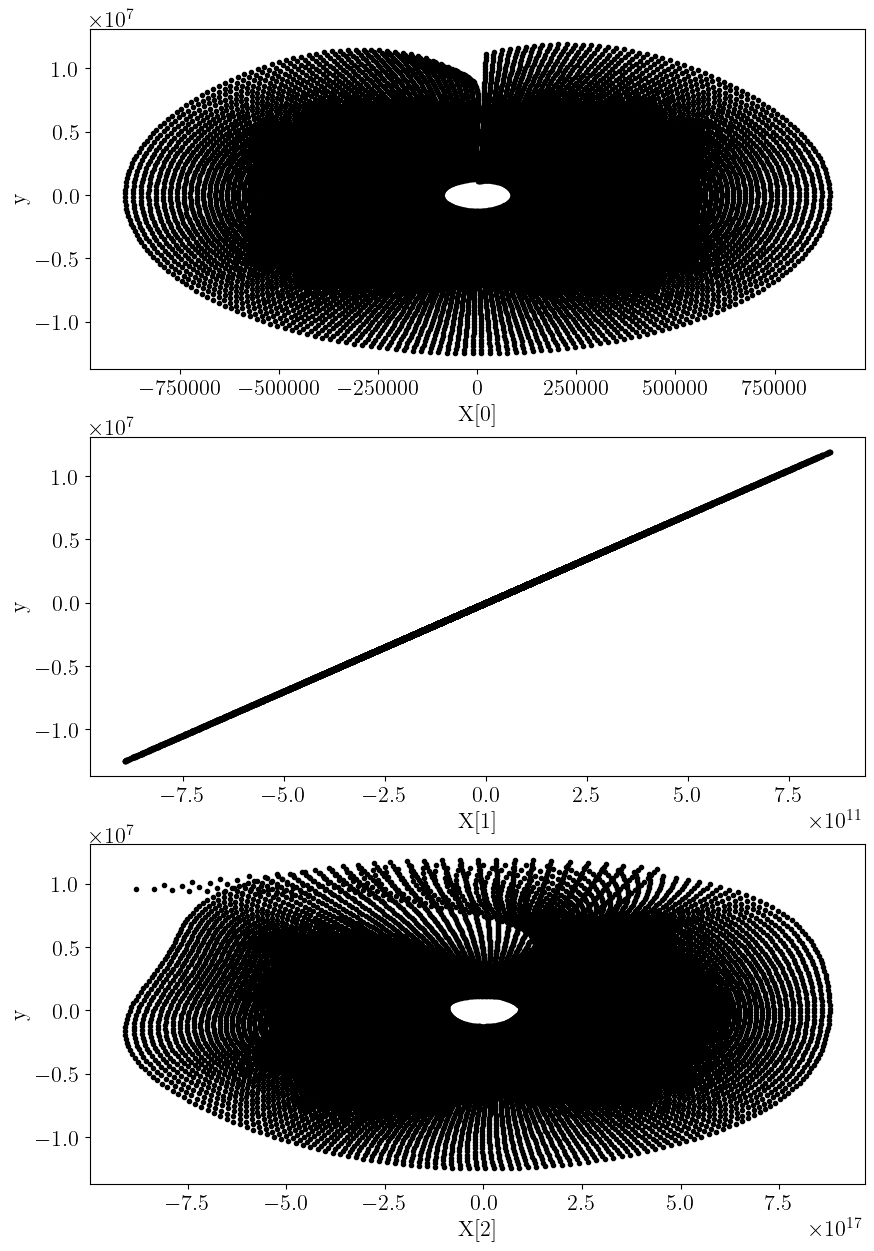

In [3]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,15))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], Y, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [4]:
# Choosing a [Mass, time, length] convention for this run
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : { "rho_y" : 0, "rho_yy" : 1, "rho_3y":2},
                "input_var_units"      : {"rho_y" : [1,0,-4], "rho_yy" : [1,0,-5], "rho_3y":[1,0,-6]},
                "input_var_complexity" : { "rho_y" : 1.    , "rho_yy" : 1.  , "rho_3y" : 1.},
                # constants
                "constants"            : {"D" : D   ,"miu" : miu       , },
                "constants_units"      : {"D" : [0, -1, 2] , "miu" : [1, -1, -1],},
                "constants_complexity" : {"D" : 1.  , "miu" : 1. , },
#                 "constants"            : {"Lambda" : Lambda   ,"tau" : tau       , },
#                 "constants_units"      : {"Lambda" : [0, 0, 1] , "tau" : [0, 1, 0],},
#                 "constants_complexity" : {"Lambda" : 1.  , "tau" : 1. , },
                # free constants
#                 "free_constants"            : {"C" , },
#                 "free_constants_init_val"   : {"C" : 1.   ,  },
#                 "free_constants_units"      : {"C" : [0, 0, 0] , },
#                 "free_constants_complexity" : {"C" : 1.  , },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [1, -1, -3],
                  "superparent_name"  : "Y",
                }

In [5]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : True,
                 "keep_lowest_complexity_duplicate" : True,
                 "parallel_mode" : True,
                 "n_cpus"        : 32,
                }

In [6]:
BATCH_SIZE = int(1e4)
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [7]:
MAX_LENGTH = 20
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : 30,
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  32
Recommended config {'parallel_mode': False, 'n_cpus': 32}


c:\users\dell\physo\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
c:\users\dell\physo\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [8]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

In [9]:


priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 5, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 12, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

In [10]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

In [11]:
save_path_training_curves = 'TG_curves1.png'
save_path_log             = 'TG1.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log,
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 5,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

In [12]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

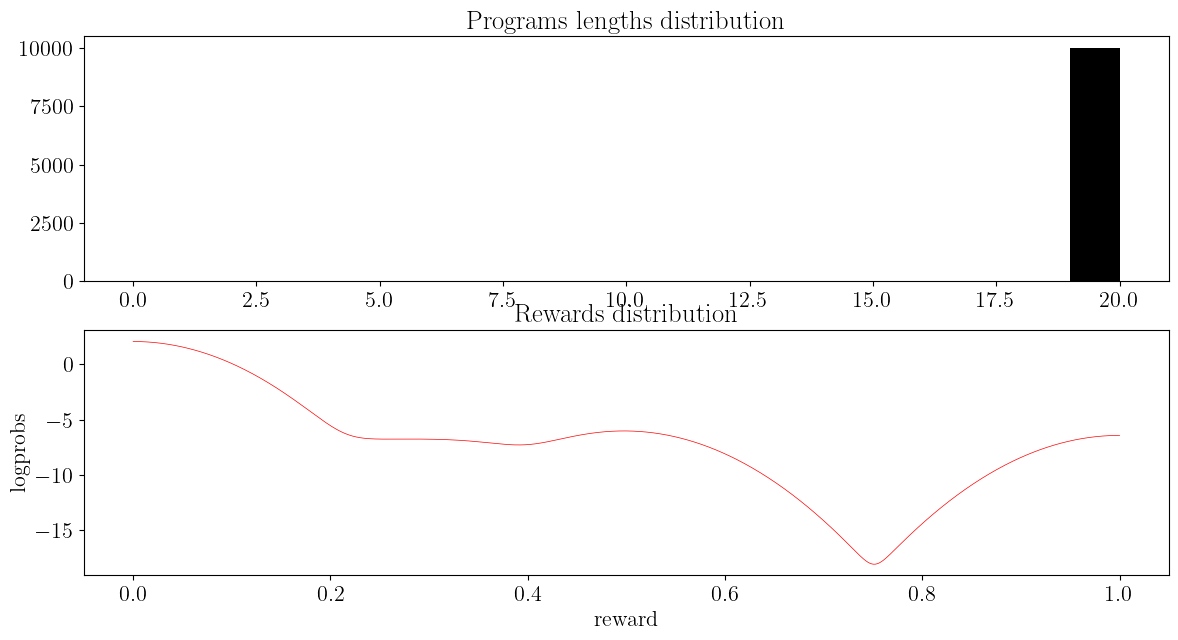

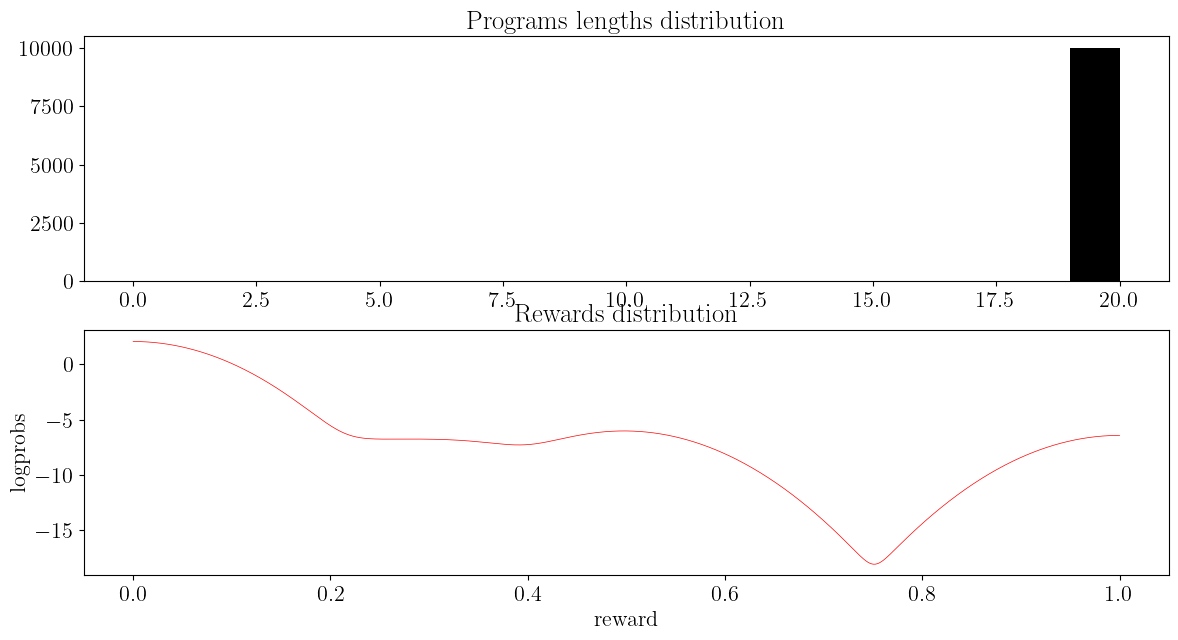

In [13]:
benchmark.dummy_epoch(X, y, run_config)

=========== Epoch 00000 ===========
-> Time 4.98 s

Overall best  at R=1.000000
-> Raw expression : 
D⋅ρ_yy⋅ρ_yy
───────────
    ρ_yy   

Best of epoch at R=1.000000
-> Raw expression : 
D⋅ρ_yy⋅ρ_yy
───────────
    ρ_yy   


=========== Epoch 00001 ===========
-> Time 2.59 s

Overall best  at R=1.000000
-> Raw expression : 
D⋅ρ_yy⋅ρ_yy
───────────
    ρ_yy   

Best of epoch at R=1.000000
-> Raw expression : 
D⋅ρ_3y⋅ρ_yy
───────────
    ρ_3y   


=========== Epoch 00002 ===========
-> Time 2.31 s

Overall best  at R=1.000000
-> Raw expression : 
D⋅ρ_yy⋅ρ_yy
───────────
    ρ_yy   

Best of epoch at R=1.000000
-> Raw expression : 
D⋅(-ρ_yy + ρ_yy + ρ_yy)


=========== Epoch 00003 ===========
-> Time 2.26 s

Overall best  at R=1.000000
-> Raw expression : 
D⋅ρ_yy⋅ρ_yy
───────────
    ρ_yy   

Best of epoch at R=1.000000
-> Raw expression : 
D⋅(-ρ_yy + ρ_yy + ρ_yy)


=========== Epoch 00004 ===========
-> Time 2.30 s

Overall best  at R=1.000000
-> Raw expression : 
D⋅ρ_yy⋅ρ_yy
───────────

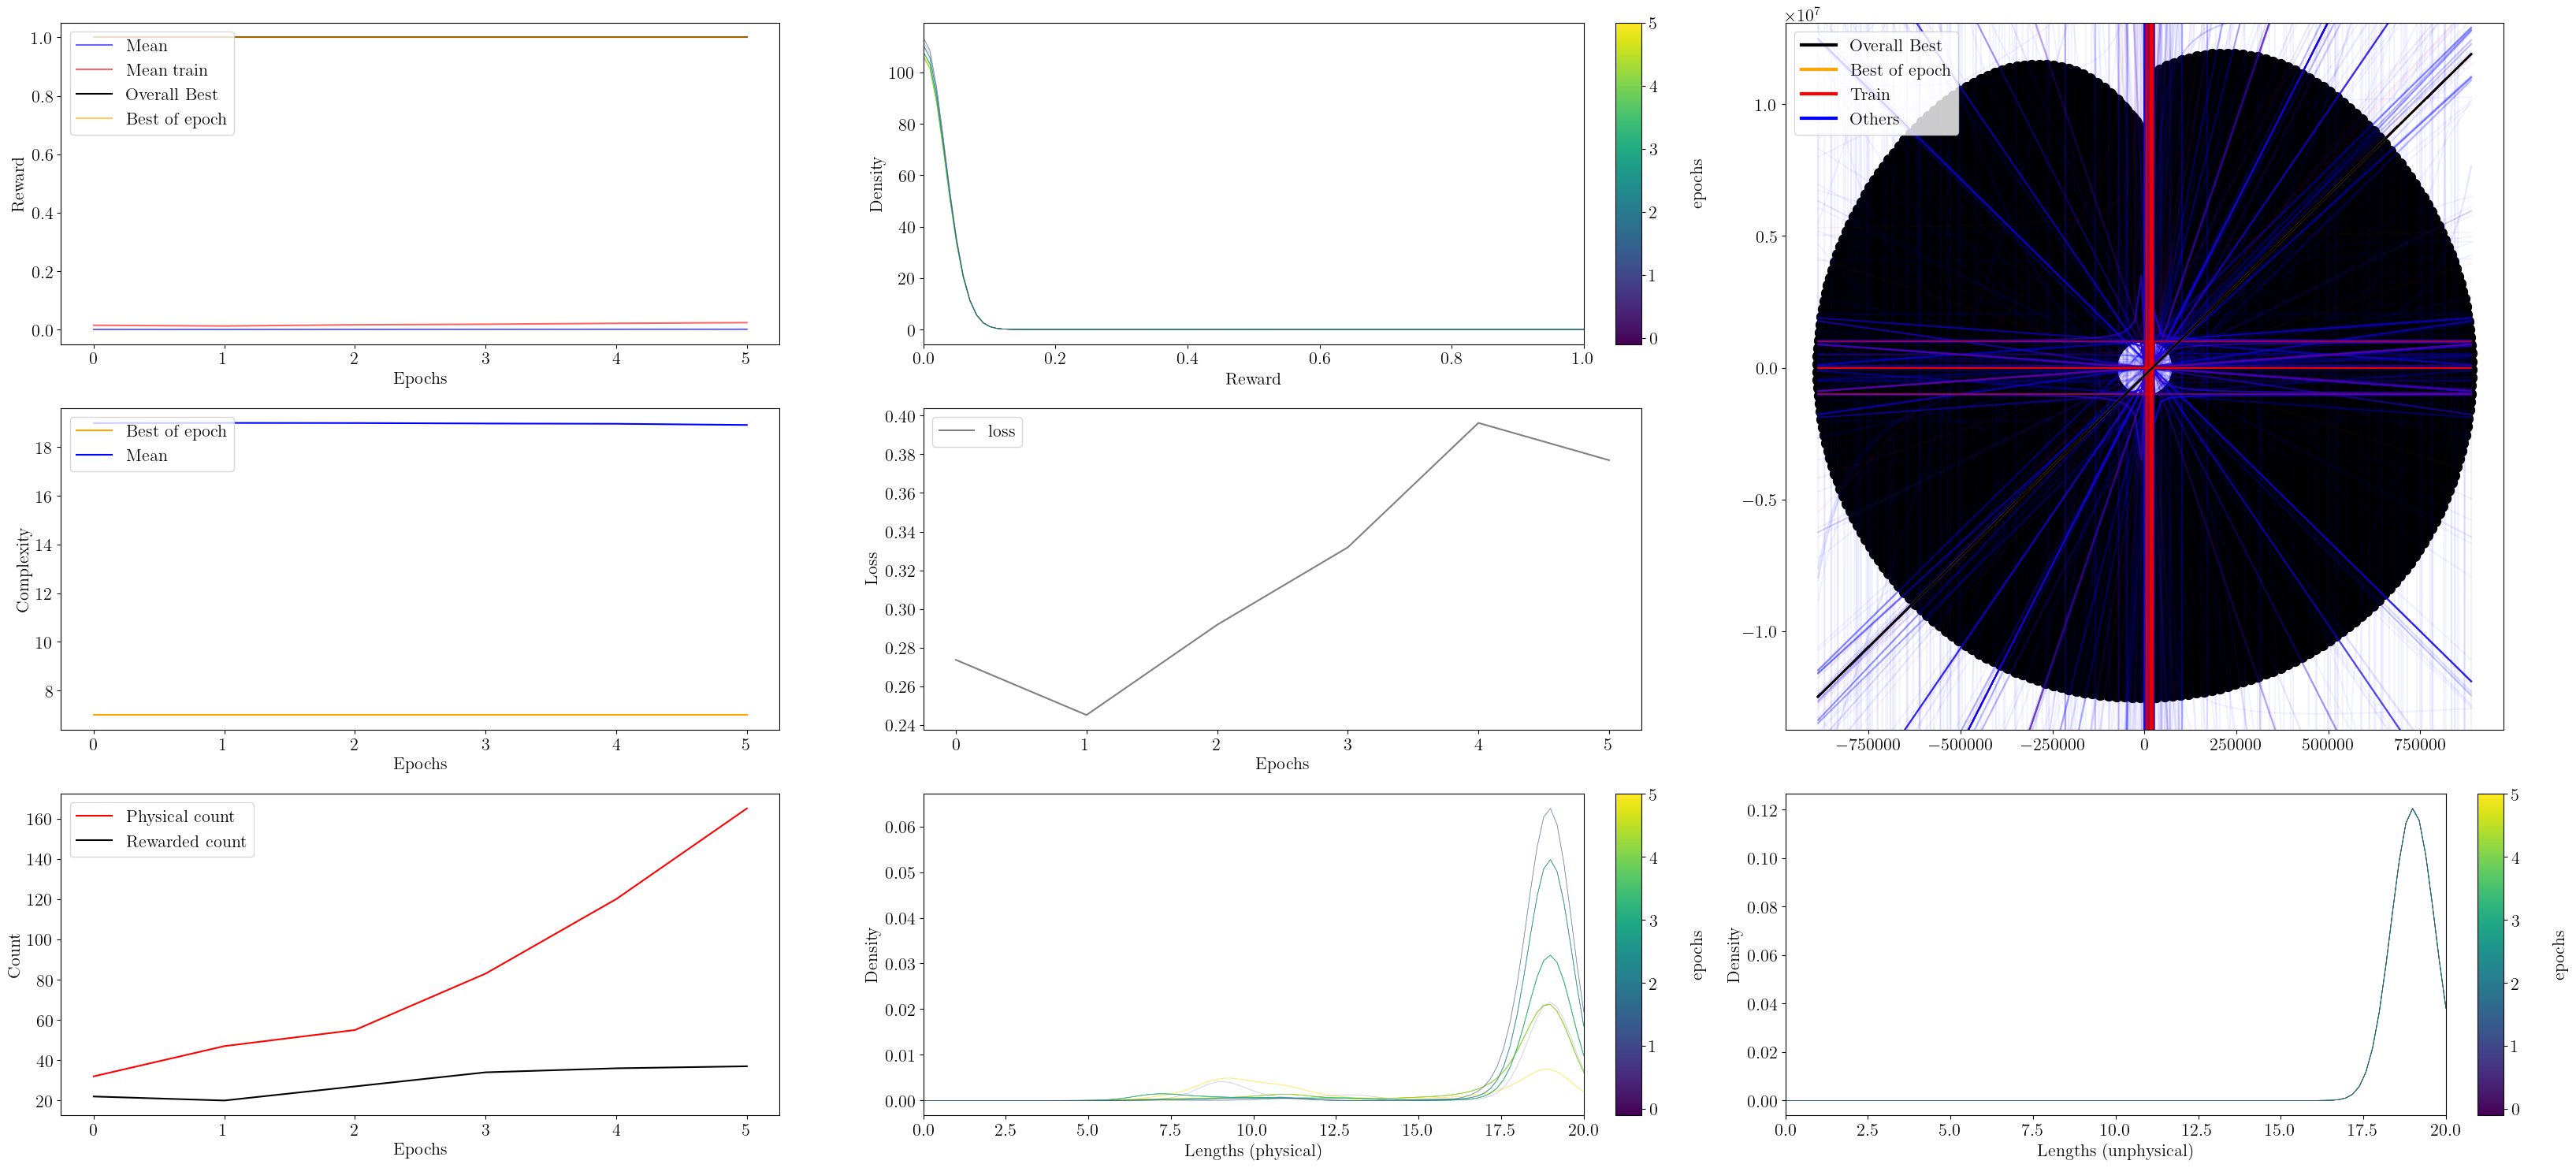

In [14]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999,
                                stop_after_n_epochs = 5)

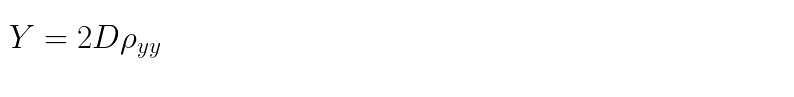

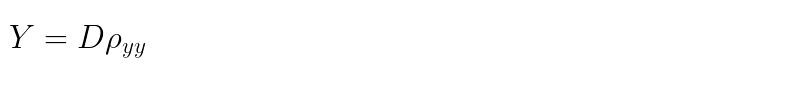

In [15]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_const_values.detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))

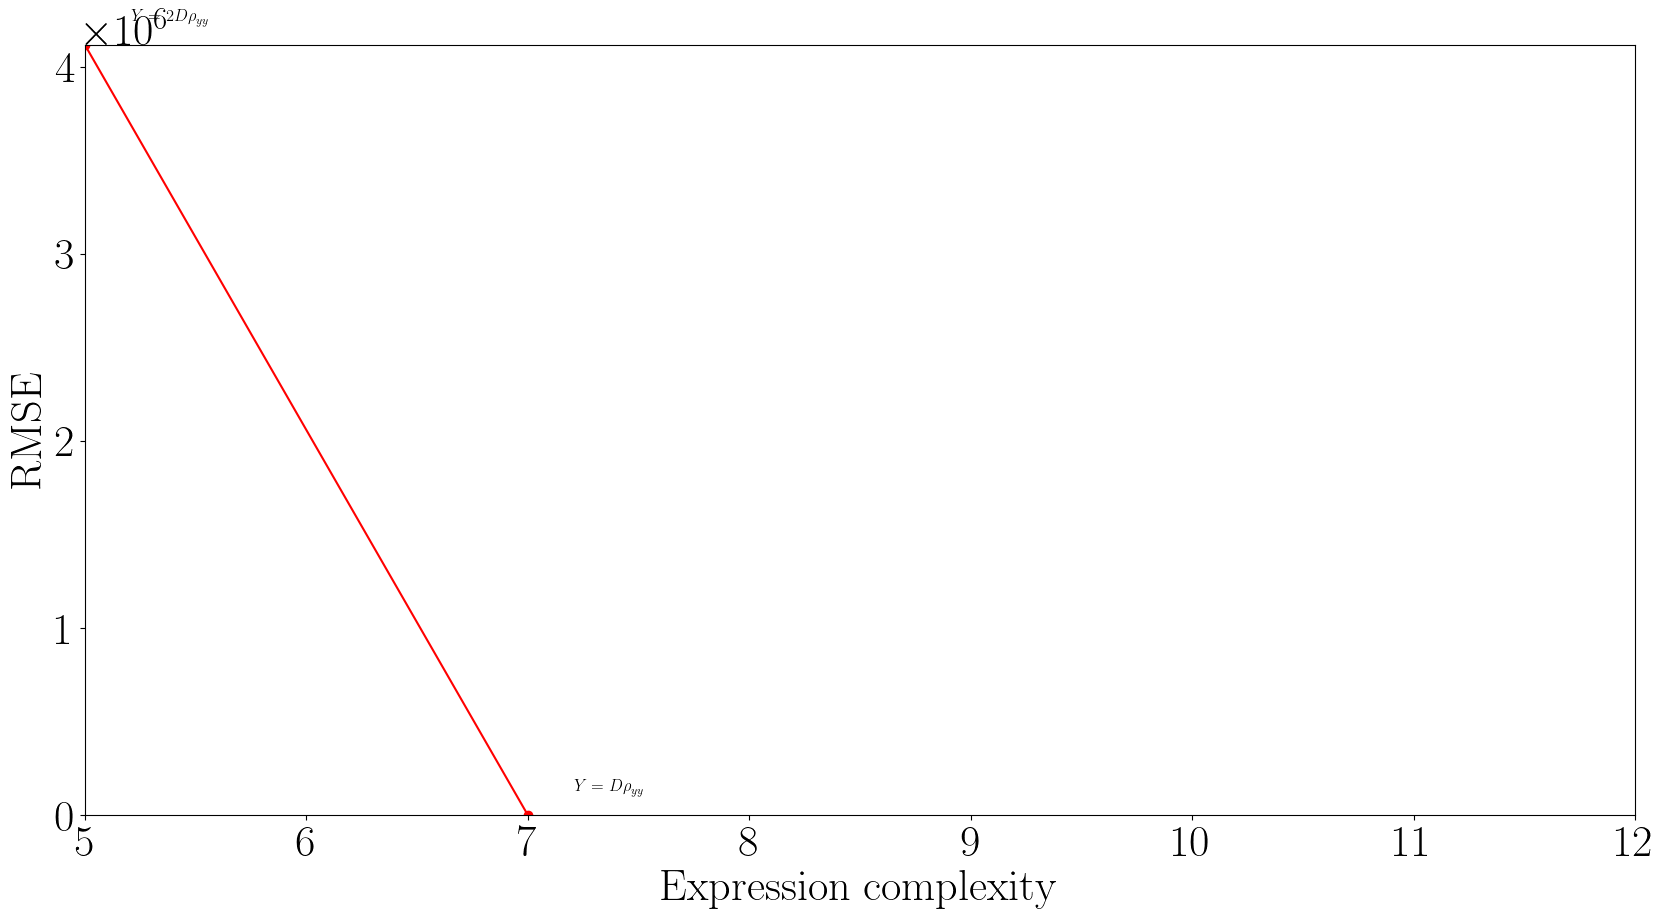

In [16]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)
        

plot_pareto_front(run_logger)